# Лабораторная работа 2: Жесткие системы ОДУ
## Модель дифференциации растительной ткани (X.9.12)

Данный пример — типичный случай биохимической модели «умеренной» размерности. Система является умеренно жесткой и имеет вид:

\begin{equation*}
\begin{cases}
y_1' = -1.71y_1 + 0.43y_2 + 8.23y_3 + 0.0007, \\
y_2' = 1.71y_1 - 8.75y_2, \\
y_3' = -10.03y_3 + 0.43y_4 + 0.035y_5, \\
y_4' = 8.32y_2 + 1.71y_3 - 1.12y_4, \\
y_5' = -1.745y_5 + 0.43y_6 + 0.43y_7, \\
y_6' = -280y_6y_8 + 0.69y_4 + 1.71y_5 - 0.43y_6 + 0.69y_7, \\
y_7' = 280y_6y_8 - 1.87y_7, \\
y_8' = -y_7.
\end{cases}
\end{equation*}

**Начальные условия:**
- $y_1(0) = 1$
- $y_8(0) = 0.0057$
- Остальные $y_i(0) = 0$ ($i = 2,\dots,7$)

**Параметры:**
- Время интегрирования: $T_{end} = 421.8122$

**Методы решения:**
1. Неявный метод Рунге-Кутты 3-го порядка и выше
2. Неявный метод Адамса или формулы дифференцирования назад (методы Гира) 3-го порядка
3. Метод Розенброка-Ваннера 2-го и 3-го порядка

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.linalg import solve

### Определение системы ОДУ и параметров

In [2]:
class PlantTissueModel:
    def __init__(self):
        # Начальные условия
        self.y0 = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0057])
        self.t_end = 421.8122  # Конечное время интегрирования
        
    def f(self, t, y):
        """Правая часть системы ОДУ"""
        y1, y2, y3, y4, y5, y6, y7, y8 = y
        return np.array([
            -1.71*y1 + 0.43*y2 + 8.23*y3 + 0.0007,
            1.71*y1 - 8.75*y2,
            -10.03*y3 + 0.43*y4 + 0.035*y5,
            8.32*y2 + 1.71*y3 - 1.12*y4,
            -1.745*y5 + 0.43*y6 + 0.43*y7,
            -280*y6*y8 + 0.69*y4 + 1.71*y5 - 0.43*y6 + 0.69*y7,
            280*y6*y8 - 1.87*y7,
            -y7
        ])
    
    def jacobian(self, t, y):
        """Якобиан системы"""
        y6, y8 = y[5], y[7]
        return np.array([
            [-1.71, 0.43, 8.23, 0, 0, 0, 0, 0],
            [1.71, -8.75, 0, 0, 0, 0, 0, 0],
            [0, 0, -10.03, 0.43, 0.035, 0, 0, 0],
            [0, 8.32, 1.71, -1.12, 0, 0, 0, 0],
            [0, 0, 0, 0, -1.745, 0.43, 0.43, 0],
            [0, 0, 0, 0.69, 1.71, -280*y8-0.43, 0.69, -280*y6],
            [0, 0, 0, 0, 0, 280*y8, -1.87, 280*y6],
            [0, 0, 0, 0, 0, 0, -1, 0]
        ])

model = PlantTissueModel()

### Решение и визуализация: Метод Рунге-Кутты 4-го порядка

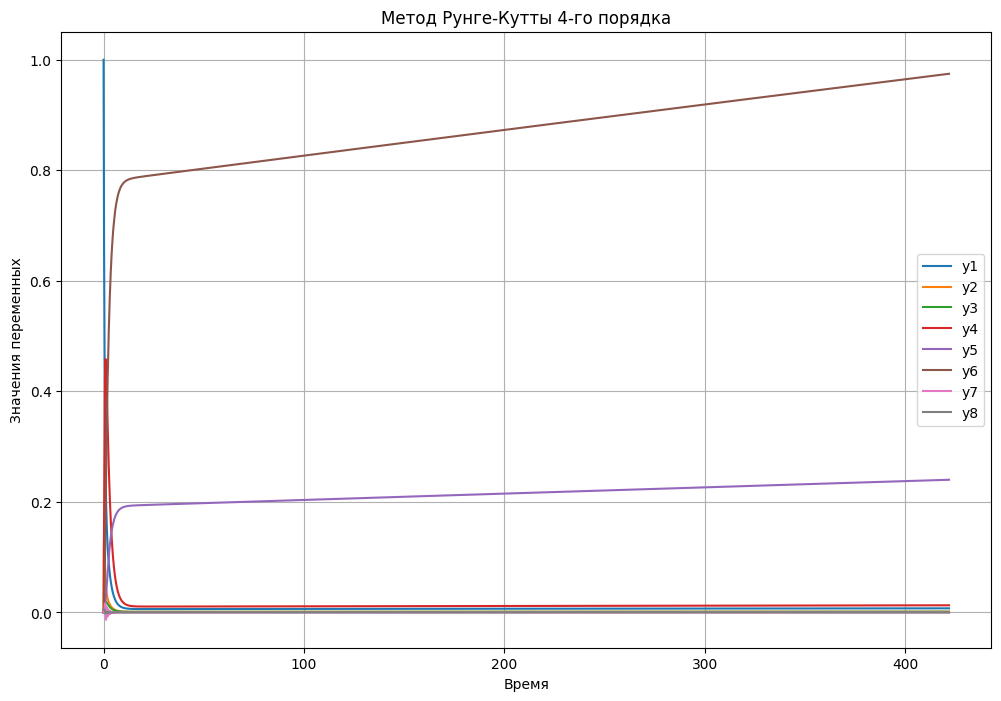

In [3]:
def rk4_step(f, t, y, dt):
    """Один шаг метода Рунге-Кутты 4-го порядка"""
    k1 = f(t, y)
    k2 = f(t + dt/2, y + dt/2 * k1)
    k3 = f(t + dt/2, y + dt/2 * k2)
    k4 = f(t + dt, y + dt * k3)
    return y + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4(model, dt):
    """Симуляция методом Рунге-Кутты 4-го порядка"""
    t_values = np.arange(0, model.t_end, dt)
    y_values = np.zeros((len(t_values), len(model.y0)))
    y_values[0] = model.y0
    
    for i in range(1, len(t_values)):
        y_values[i] = rk4_step(model.f, t_values[i-1], y_values[i-1], dt)
    
    return t_values, y_values

# Решение
dt_rk4 = 0.01
t_rk4, y_rk4 = simulate_rk4(model, dt_rk4)

# Визуализация
plt.figure(figsize=(12, 8))
variables = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8']
for i in range(8):
    plt.plot(t_rk4, y_rk4[:, i], label=variables[i])
plt.title('Метод Рунге-Кутты 4-го порядка')
plt.xlabel('Время')
plt.ylabel('Значения переменных')
plt.legend()
plt.grid(True)
plt.show()

### Решение и визуализация: Неявный метод Рунге-Кутты 3-го порядка

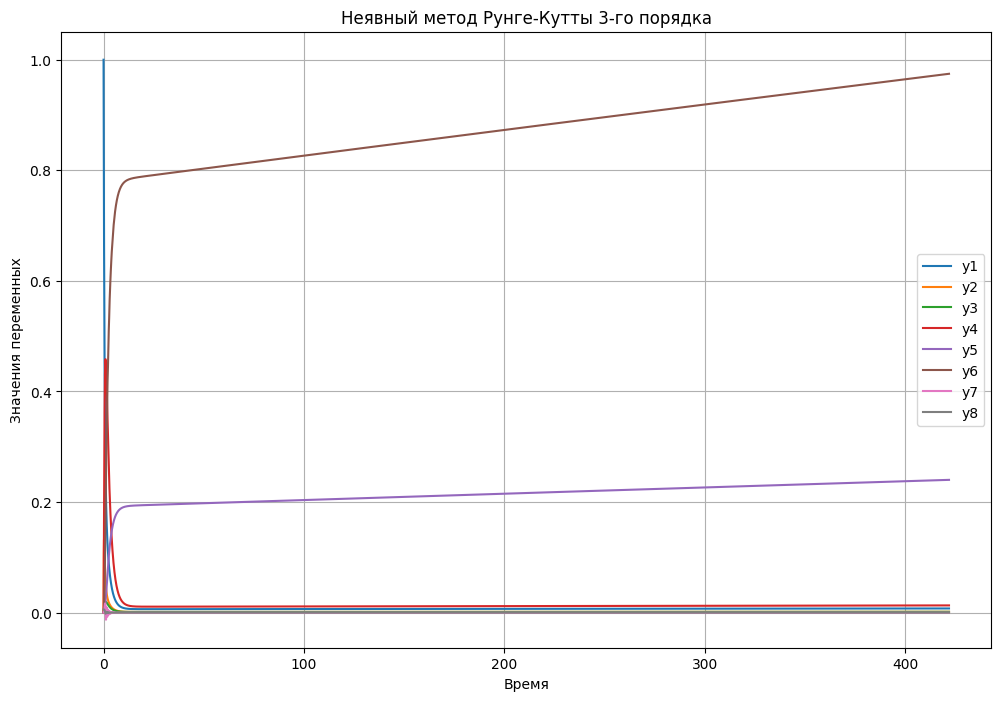

In [14]:
def implicit_rk3_step(f, jac, t, y, h):
    """Один шаг неявного метода РК3"""
    gamma = 0.5 + np.sqrt(3)/6
    a = np.array([[gamma, 0], [1-2*gamma, gamma]])
    b = np.array([0.5, 0.5])
    c = np.array([gamma, 1-gamma])

    def equations(k):
        k1, k2 = k[:8], k[8:]
        return np.concatenate([
            k1 - f(t + c[0]*h, y + h*(a[0,0]*k1 + a[0,1]*k2)),
            k2 - f(t + c[1]*h, y + h*(a[1,0]*k1 + a[1,1]*k2))
        ])

    k_sol = fsolve(equations, np.zeros(16))
    k1, k2 = k_sol[:8], k_sol[8:]
    return y + h * (b[0]*k1 + b[1]*k2)

def simulate_implicit_rk3(model, h):
    t_values = np.arange(0, model.t_end, h)
    y_values = np.zeros((len(t_values), len(model.y0)))
    y_values[0] = model.y0

    for i in range(1, len(t_values)):
        y_values[i] = implicit_rk3_step(model.f, model.jacobian, t_values[i-1], y_values[i-1], h)

    return t_values, y_values

# Решение
h_rk3 = 0.05
t_rk3, y_rk3 = simulate_implicit_rk3(model, h_rk3)

# Визуализация
plt.figure(figsize=(12, 8))
variables = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8']
for i in range(8):
    plt.plot(t_rk3, y_rk3[:, i], label=variables[i])
plt.title('Неявный метод Рунге-Кутты 3-го порядка')
plt.xlabel('Время')
plt.ylabel('Значения переменных')
plt.legend()
plt.grid(True)
plt.show()

### Решение и визуализация: Метод Адамса 3-го порядка

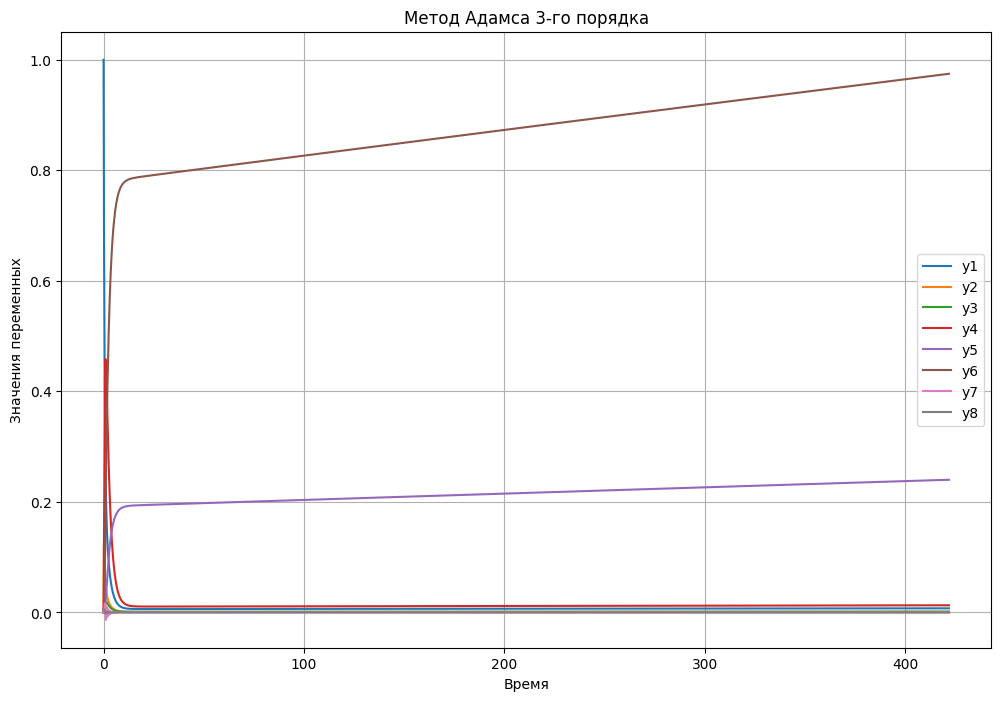

In [16]:
def simulate_adams3(model, h):
    t_values = np.arange(0, model.t_end, h)
    y_values = np.zeros((len(t_values), len(model.y0)))
    
    y_values[0] = model.y0
    y_values[1] = rk4_step(model.f, t_values[0], y_values[0], h)
    y_values[2] = rk4_step(model.f, t_values[1], y_values[1], h)
    
    # Инициализация f_prev: [f0, f1, f2]
    f_prev = [model.f(t_values[i], y_values[i]) for i in range(3)]
    
    for i in range(3, len(t_values)):
        # Предиктор (Adams-Bashforth 4-го порядка)
        y_pred = y_values[i-1] + h/24 * (55*f_prev[2] - 59*f_prev[1] + 37*f_prev[0] - 9*model.f(t_values[i-3], y_values[i-3]))
        
        # Корректор (Adams-Moulton 3-го порядка)
        f_pred = model.f(t_values[i], y_pred)
        y_corr = y_values[i-1] + h/24 * (9*f_pred + 19*f_prev[2] - 5*f_prev[1] + f_prev[0])
        
        y_values[i] = y_corr
        
        # Обновляем f_prev: удаляем f_{n-3}, добавляем f_n
        f_prev.pop(0)
        f_prev.append(model.f(t_values[i], y_values[i]))
    
    return t_values, y_values

# Решение
h_adams3 = 0.005
t_adams3, y_adams3 = simulate_adams3(model, h_adams3)

# Визуализация
plt.figure(figsize=(12, 8))
variables = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8']
for i in range(8):
    plt.plot(t_adams3, y_adams3[:, i], label=variables[i])
plt.title('Метод Адамса 3-го порядка')
plt.xlabel('Время')
plt.ylabel('Значения переменных')
plt.legend()
plt.grid(True)
plt.show()

### Решение и визуализация: Метод Розенброка 3-го порядка

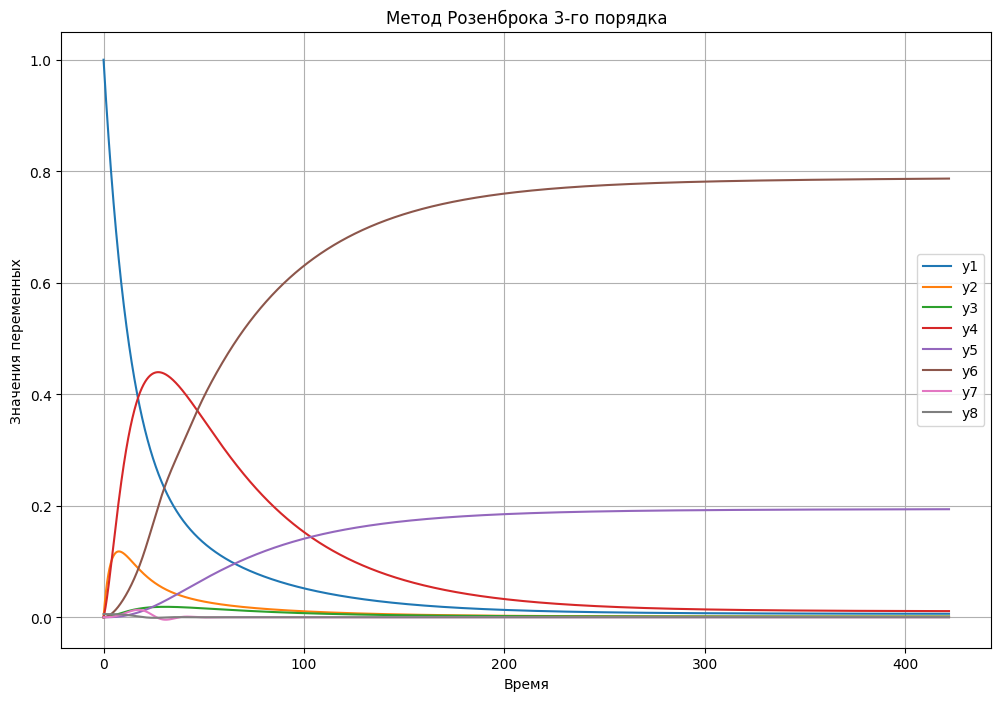

In [ ]:
def rosenbrock_step(f, jac, t, y, h):
    """Один шаг метода Розенброка-Ваннера 3-го порядка"""
    gamma = 0.5 + np.sqrt(3)/6
    J = jac(t, y)
    I = np.eye(len(y))

    # Первая стадия
    k1 = solve(I/(gamma*h) - J, f(t, y))

    # Вторая стадия
    k2 = solve(I/(gamma*h) - J,
              f(t + 0.5*h, y + 0.5*h*k1) - (2*gamma-1)*k1)

    return y + h*k2

def simulate_rosenbrock(model, h):
    t_values = np.arange(0, model.t_end, h)
    y_values = np.zeros((len(t_values), len(model.y0)))
    y_values[0] = model.y0

    for i in range(1, len(t_values)):
        y_values[i] = rosenbrock_step(model.f, model.jacobian, t_values[i-1], y_values[i-1], h)

    return t_values, y_values

# Решение
h_rosenbrock = 0.05
t_rosenbrock, y_rosenbrock = simulate_rosenbrock(model, h_rosenbrock)

# Визуализация
plt.figure(figsize=(12, 8))
variables = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8']
for i in range(8):
    plt.plot(t_rosenbrock, y_rosenbrock[:, i], label=variables[i])
plt.title('Метод Розенброка 3-го порядка')
plt.xlabel('Время')
plt.ylabel('Значения переменных')
plt.legend()
plt.grid(True)
plt.show()